In [13]:
import re
import os
import keras
import numpy as np
import pandas as pd

from PIL import Image

from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import combinations

%matplotlib inline

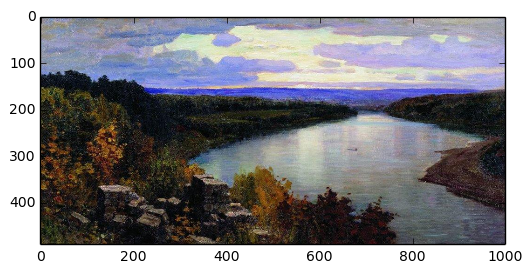

In [14]:
plt.imshow(plt.imread('/datasets/kaggle/painters/train/1000.jpg'))

In [15]:
#np.random.seed(seed=100500)

In [24]:
TRAIN_DATA_DIR = '/datasets/kaggle/painters/train/'

ENCODED_DATA_DIR = {
    'bottlenecks': 'out/bottlenecks',
    'dimensions': 'out/dimensions'
}

SAMPLES_FILE = 'out/samples-2m'

# how many same-artist samples to include
SAME_ARTIST_PROB = 0.5

# number of samples
SAMPLES_N = 2000000

In [25]:
def get_same_pair():
    return same_artist_fids[np.random.randint(len(same_artist_fids))]

def get_different_pair():
    pair = None    
    while pair is None or \
        (pair[0] == pair[1]) or \
        (info_df.ix[pair[0]].artist == info_df.ix[pair[1]].artist):
        pair = np.random.choice(avail_fids, 2, replace=True)
    return pair

In [26]:
# create sample from bottlecks and aspects of a pair of images
def get_sample(fid):
    bottleneck = np.fromfile(ENCODED_DATA_DIR['bottlenecks'] + '/' + str(fid), dtype=np.float32)
    dims = np.fromfile(ENCODED_DATA_DIR['dimensions'] + '/' + str(fid), dtype=np.float32)
    return bottleneck, dims

In [19]:
# get training info
info_df = pd.read_csv('train_info.csv')
info_df['fid'] = [int(re.findall(r'(\d+).jpg$', x)[0]) for x in info_df['filename']]
info_df = info_df.set_index('fid', drop=True)

In [8]:
# generate pairs of fids with the same artist
artists = np.unique(info_df.artist.values)
same_artist_fids = []

for a in tqdm(artists):
    info_artist_df = info_df[info_df['artist'] == a]
    
    for c in combinations(info_artist_df.index.values, 2):
        same_artist_fids.append(c)

same_artist_fids = np.array(same_artist_fids, dtype=np.int32)
np.random.shuffle(same_artist_fids)

100%|██████████| 1584/1584 [00:04<00:00, 333.74it/s]


In [20]:
print "# same-artist pairs: %d"%(len(same_artist_fids))

# same-artist pairs: 5773652


In [21]:
# fids in the training set
avail_fids = np.array(info_df.index.values, dtype=np.int32)
print "# fids in training set: %d"%(len(avail_fids))

# fids in training set: 79433


In [27]:
# memory-mapped records store
records = np.memmap(SAMPLES_FILE, dtype=np.float32, mode='write', shape=(SAMPLES_N,4102))

In [28]:
for i in tqdm(range(SAMPLES_N)):
    
    if np.random.rand() < SAME_ARTIST_PROB:
        same_artist = [1., 0.]
        pair = get_same_pair()    
    else:
        same_artist = [0., 1.]
        pair = get_different_pair()
        
    s1 = get_sample(pair[0])
    s2 = get_sample(pair[1])
    
    record = np.concatenate((
            pair, # fids                         x2
            same_artist,   # same/diff artist?   x2
            [s1[1][0] / s1[1][1]], # image 1 AR  x1
            [s2[1][0] / s2[1][1]], # image 2 AR  x1
            s1[0], # image 1 features            x2048
            s2[0] # image 2 features             x2048
        ))
    
    records[i] = record

100%|██████████| 2000000/2000000 [09:03<00:00, 3676.85it/s]


In [13]:
# r = np.memmap(SAMPLES_FILE, dtype=np.float32, mode='r+', shape=(SAMPLES_N,4102))

(array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   4.00000000e+00,   6.00000000e+00,
          2.00000000e+00,   9.00000000e+00,   2.80000000e+01,
          6.60000000e+01,   9.30000000e+01,   1.68000000e+02,
          2.47000000e+02,   4.59000000e+02,   4.56000000e+02,
          4.78000000e+02,   4.39000000e+02,   5.83000000e+02,
          8.12000000e+02,   8.30000000e+02,   9.95000000e+02,
          1.80400000e+03,   1.81700000e+03,   1.85300000e+03,
          1.90500000e+03,   2.37600000e+03,   3.81900000e+03,
          5.01000000e+03,   7.47100000e+03,   1.05620000e+04,
          1.30170000e+04,   1.60960000e+04,   1.69930000e+04,
          2.17370000e+04,   2.54240000e+04,   2.43790000e+04,
          2.59370000e+04,   2.39840000e+04,   1.86610000e+04,
          8.93200000e+03,   6.23900000e+03,   4.53800000e+03,
          3.27100000e+03,   3.45700000e+03,   2.80700000e+03,
        

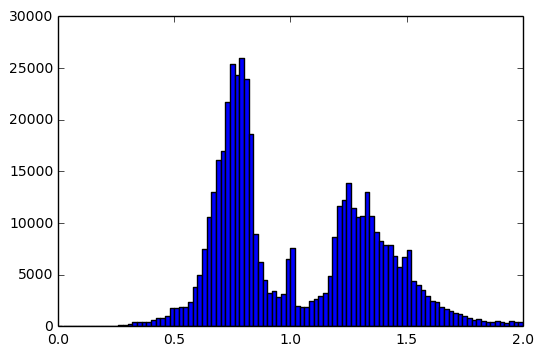

In [13]:
plt.hist(records.T[4], range=(0,2), bins=100) # AR (w/h) for img1

(array([ 250362.,  249638.]),
 array([ 0. ,  0.5,  1. ]),
 <a list of 2 Patch objects>)

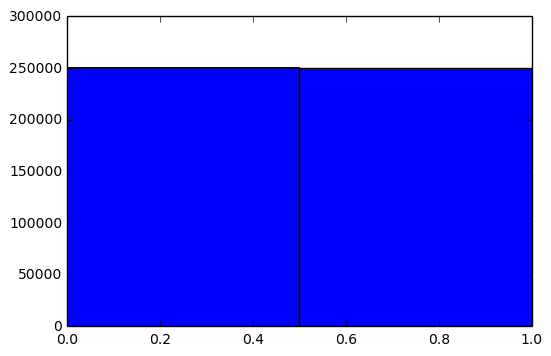

In [14]:
plt.hist(records.T[2], range=(0,1), bins=2) # same vs diff